In [1]:
#svm_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#5 July 2018
#
#train svm model

In [2]:
#set system parameters
N_dots = 100000
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [3]:
#generate training data
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
train.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
99995,99995,-2.763331,0.612411,2.830379,2.923497,B,0.0,0.0,1.0
99996,99996,-0.060884,-6.579852,6.580134,-1.580049,B,0.0,0.0,1.0
99997,99997,8.886147,0.228891,8.889095,0.025753,B,0.0,0.0,1.0
99998,99998,-1.548288,7.778756,7.931345,1.767269,B,0.0,0.0,1.0
99999,99999,2.693783,2.166376,3.456827,0.677305,X,1.0,0.0,0.0


In [4]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

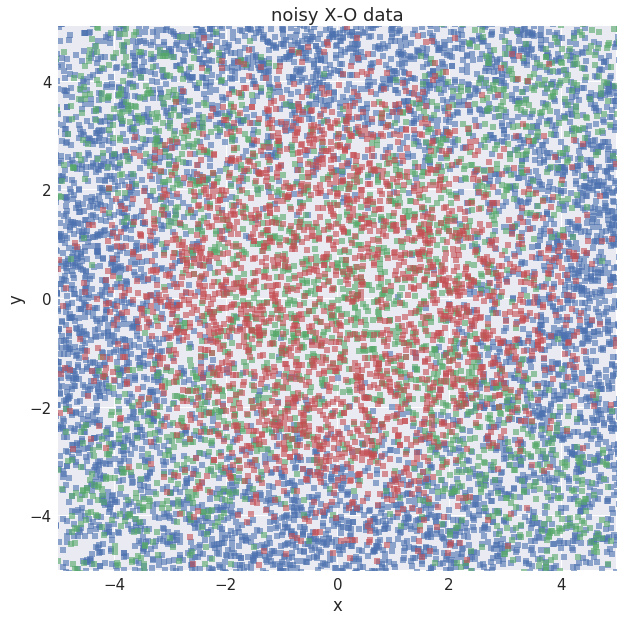

In [5]:
#scatterplot of a sample of noisy training data
N_plot = N_dots/5
df = train.sample(N_plot)
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/training_data.png')

In [6]:
#check class balance
cols = ['id', 'class']
N = train[cols].groupby('class').count().sort_values('id')
N = N*1.0/N.min()
N

,id
class,
O,1.000000
X,1.073175
B,5.786607


In [7]:
#get features x and target variable y
x_cols = ['x', 'y']
y_col = 'class'
x = df[x_cols]
y = df[y_col]

In [8]:
#fit SVM model to training data
from sklearn import svm
svm_model = svm.SVC(decision_function_shape='ovr').fit(x, y) 